## Imports

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import matplotlib
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix, vstack, lil_matrix
from os.path import isfile
import h5py
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from scipy import sparse, io
import time

%matplotlib inline

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load & Preprocess

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
def process_comment_text(txt):
    ntxt = re.sub(r"[^a-zA-Z]", " ", txt)
    ntxt = ntxt.lower()
    lemmatizer = WordNetLemmatizer()
    text = nltk.word_tokenize(ntxt)
    return ' '.join([lemmatizer.lemmatize(w,'v') for w in text])

train_data['processed'] = train_data.comment_text.apply(process_comment_text)
test_data['processed'] = test_data.comment_text.apply(process_comment_text)
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edit make under my usernam...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he match this background colour i m seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i m really not try to edit war it s ju...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can t make any real suggestions on impr...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir be my hero any chance you remember wha...


# Make features

In [4]:
# see how frequent frequent words are
stop = set(stopwords.words('english'))
text = nltk.word_tokenize(' '.join(train_data.processed.values))
dist = nltk.FreqDist(text)
freq=[(w, dist[w]) for w in sorted(dist, key=dist.get, reverse=True) if w not in stop]

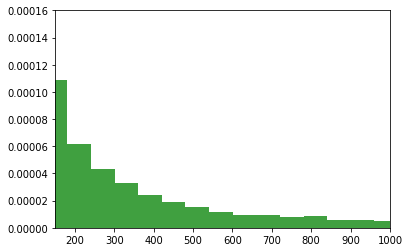

In [42]:
import matplotlib.pyplot as plt
x =np.asarray([i for i in dist.values()])
plt.hist(x[x<6000],bins=100,density=True, facecolor='g', alpha=0.75)
plt.axis([150,1000,0,0.000160000])
plt.show()

In [5]:
print(freq[:20])
print(freq[-20:])

[('article', 74553), ('page', 57296), ('wikipedia', 48625), ('edit', 40862), ('talk', 40500), ('use', 33257), ('make', 30575), ('please', 29976), ('would', 29323), ('one', 29199), ('like', 28739), ('think', 25743), ('see', 25574), ('say', 25520), ('know', 24313), ('source', 23941), ('thank', 23896), ('get', 22857), ('go', 21878), ('also', 20643)]
[('wheatear', 1), ('dracul', 1), ('bestbuy', 1), ('itried', 1), ('defaultsorting', 1), ('mischievious', 1), ('photocatbot', 1), ('mufaddalqn', 1), ('samanthapuckettindo', 1), ('markdrows', 1), ('murtazajamali', 1), ('distributorscientiae', 1), ('hispavista', 1), ('amblocked', 1), ('bmattson', 1), ('webaddress', 1), ('gratest', 1), ('hanumakonda', 1), ('automakers', 1), ('ciu', 1)]


In [6]:
def getwordlist(data,minfreq,maxfreq):
    stop = set(stopwords.words('english'))
    text = nltk.word_tokenize(' '.join(data))
    dist = nltk.FreqDist(text)
    wordlist = [i for i in dist.keys() if dist[i]>minfreq and dist[i]<maxfreq and i not in stop]
    return wordlist

words = getwordlist(data=train_data.processed.values,minfreq=5,maxfreq=80000)

In [8]:
def make_features(data,name):
    X = csr_matrix((0, len(words)))

    # for every comment check if the words corresponding to our input vector exist
    count=0
    print(name)
    for i in data.processed: #.loc[:100]:
        if count%1000==0:
            print(round(((count+1)/len(data.processed))*100,3),'%')
        cw = set(nltk.word_tokenize(i))
        add = [int(w in cw) for w in words]
        X = vstack([X, csr_matrix(add)], 'csr')
        count+=1
    io.mmwrite(name+'_X.mtx', X)
    
    if len(data.columns)>3:
        y = data.apply(lambda x: x[2:8],axis=1) # .loc[:100]
        y = csr_matrix(y.values)
        io.mmwrite(name+'_y.mtx', y)
    
    # X is shape (number of examples in the data) x (numer of feature words) 

In [9]:
make_features(train_data,'train_data')
make_features(test_data,'test_data')

train_data
0.001 %
0.627 %
1.254 %
1.881 %
2.507 %
3.134 %
3.761 %
4.387 %
5.014 %
5.641 %
6.267 %
6.894 %
7.521 %
8.147 %
8.774 %
9.401 %
10.028 %
10.654 %
11.281 %
11.908 %
12.534 %
13.161 %
13.788 %
14.414 %
15.041 %
15.668 %
16.294 %
16.921 %
17.548 %
18.174 %
18.801 %
19.428 %
20.054 %
20.681 %
21.308 %
21.934 %
22.561 %
23.188 %
23.814 %
24.441 %
25.068 %
25.695 %
26.321 %
26.948 %
27.575 %
28.201 %
28.828 %
29.455 %
30.081 %
30.708 %
31.335 %
31.961 %
32.588 %
33.215 %
33.841 %
34.468 %
35.095 %
35.721 %
36.348 %
36.975 %
37.601 %
38.228 %
38.855 %
39.481 %
40.108 %
40.735 %
41.362 %
41.988 %
42.615 %
43.242 %
43.868 %
44.495 %
45.122 %
45.748 %
46.375 %
47.002 %
47.628 %
48.255 %
48.882 %
49.508 %
50.135 %
50.762 %
51.388 %
52.015 %
52.642 %
53.268 %
53.895 %
54.522 %
55.148 %
55.775 %
56.402 %
57.029 %
57.655 %
58.282 %
58.909 %
59.535 %
60.162 %
60.789 %
61.415 %
62.042 %
62.669 %
63.295 %
63.922 %
64.549 %
65.175 %
65.802 %
66.429 %
67.055 %
67.682 %
68.309 %
68.935 %
69.562

## Load data

In [6]:
X_train = io.mmread('train_data_X.mtx').tocsr()
y_train = io.mmread('train_data_y.mtx').tocsr()
X_test = io.mmread('test_data_X.mtx').tocsr()

## Specify model

In [10]:
nout = y_train.shape[1]
nin = X_train.shape[1]

model = Sequential()
model.add(Dense(100, input_dim=nin, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nout, activation='softmax'))

In [11]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Fit model

In [15]:
# to deal with sparse matrix, add generator: https://stackoverflow.com/questions/41538692/using-sparse-matrices-with-keras-and-tensorflow
def batch_generator(X, y, batch_size):
    number_of_batches = X.shape[0]/batch_size
    counter=0
    shuffle_index = np.arange(y.shape[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch].todense()
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

# settings for fitting
size_batch = 64
nb_epoch=5
prop_data=0.1

# get indices to train on
#rand = np.arange(X_train.shape[0])
#np.random.shuffle(rand)
#indices=rand #[0:int(X_train.shape[0]*prop_data)]
# [indices,:]

# model checkpoints
# callback=[ModelCheckpoint(filepath='model_'+time.strftime("%Y%m%d-%H%M%S")+'.h5', verbose=1, save_best_only=True)]

# fit
model.fit_generator(batch_generator(X_train, y_train, size_batch),X_train.shape[0], nb_epoch, verbose=1,callbacks=callback)

Epoch 1/5
15957/15957 [==============================] - 569s - loss: 0.2112 - acc: 0.8140      

/usr/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 7171/15957 [============>.................] - ETA: 311s - loss: 0.1980 - acc: 0.6766

KeyboardInterrupt: 

## Load Model

In [3]:
train_data = pd.read_pickle('train.pkl')
test_data = pd.read_pickle('test.pkl')
words = np.load('wordlist.npy').tolist()
X_test = io.mmread('test_data_X.mtx').tocsr()
model = load_model('model_20180212.h5')

## Check Predictions

In [6]:
pred = model.predict(X_test.todense(),verbose=1)

152768/153164 [============================>.] - ETA: 0s 

In [10]:
pred.shape
train_data.columns[:8]

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

## Save Results

In [23]:
# put predictions into right format for saving
res = pd.DataFrame(columns=['id','toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], index = test_data.index)
res[res.columns[1:8]]=pred
res['id'] = test_data['id']
res

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.377525,0.00958541,0.322377,0.000503212,0.288713,0.00129644
1,0000247867823ef7,0.168572,0.165549,0.16737,0.167985,0.165964,0.164561
2,00013b17ad220c46,0.172227,0.166845,0.168724,0.164564,0.163989,0.163651
3,00017563c3f7919a,0.171079,0.166687,0.168059,0.16627,0.164593,0.163312
4,00017695ad8997eb,0.172101,0.166422,0.168243,0.163515,0.164694,0.165026
5,0001ea8717f6de06,0.172223,0.165398,0.167813,0.165783,0.163697,0.165086
6,00024115d4cbde0f,0.170667,0.16687,0.168043,0.166058,0.164458,0.163903
7,000247e83dcc1211,0.91336,0.00143279,0.0177531,0.00469997,0.0600394,0.00271494
8,00025358d4737918,0.163225,0.161873,0.167117,0.169219,0.163229,0.175337
9,00026d1092fe71cc,0.171394,0.164956,0.169083,0.165801,0.165567,0.1632


In [24]:
res.to_csv('NNwords.csv',index=False)